#### Student Name: Zheng Hanming
#### Student ID: 21225621

In [157]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.feature_selection import RFE
from sklearn import svm
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import warnings


def warn(*args, **kwargs):
    pass


warnings.warn = warn


#### Helpers

In [158]:
def train_model(param_grid, regressor, X_train, y_train):
    full_pipeline = Pipeline(steps=[('preprocess', preprocess_pipeline),
                                    ('reduce_dim', 'passthrough'),
                                    ('regression', regressor)])
    search = GridSearchCV(full_pipeline, param_grid, n_jobs=-1, cv=5, refit=True)
    search.fit(X_train, y_train)

    best = {
        'params': search.best_params_,
        'model': search.best_estimator_,
        'score': search.best_score_
    }

    print("--------------------------------------------------------------------------------------")
    print(f"Best CV score({regressor.__class__.__name__}): {round(best.get('score'), 3)}")
    print(f"Best parameters({regressor.__class__.__name__}): {best.get('params')}")

    return best


def evaluate_model(X_test, y_test, model):

    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)

    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)

    return _mse, _mae, _r2


def evaluate_models(X_test, y_test, bests=[]):
    mse_result = {}
    mae_result = {}
    r2_result = {}
    for best in bests:
        name = best.get('model').steps[-1][1].__class__.__name__
        mse, mae, r2 = evaluate_model(X_test, y_test, best.get('model'))
        mse_result[name] = mse
        mae_result[name] = mae
        r2_result[name] = r2

    df_mse = pd.DataFrame(mse_result, index=['MSE'])
    df_mae = pd.DataFrame(mae_result, index=['MAE'])
    df_r2 = pd.DataFrame(r2_result, index=['R2'])
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
    df_mse.plot.bar(rot=0, ax=axes[0])
    df_mae.plot.bar(rot=0, ax=axes[1])
    df_r2.plot.bar(rot=0, ax=axes[2])
    plt.show()


#### EDA

In [159]:
df = pd.read_csv("./insurance.csv")
df.head()


age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [160]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [161]:
df.query('insurance_cost == 0 or age == 0')

Empty DataFrame
Columns: [age, gender, bmi, children, smoker, region, insurance_cost]
Index: []

In [162]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

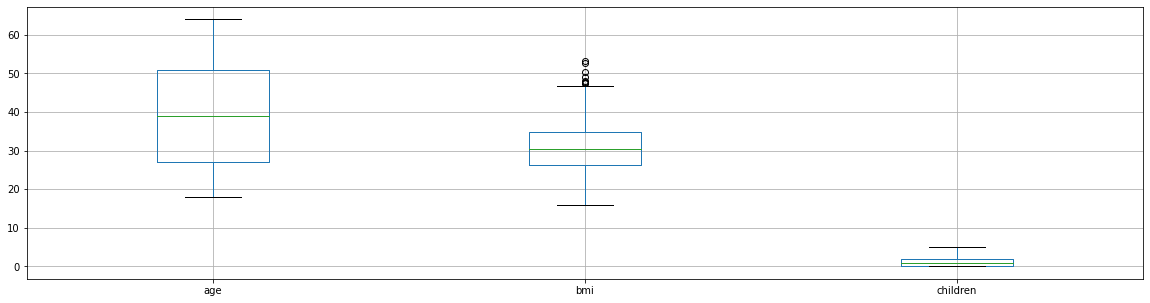

In [163]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20, 5))
plt.show()


#### Data Preparation

In [164]:
df = pd.get_dummies(df, columns=['gender', 'smoker', 'region'], drop_first=True)
df.head()

age     bmi  children  insurance_cost  gender_male  smoker_yes  \
0   18  33.770         1      1725.55230            1           0   
1   18  34.100         0      1137.01100            1           0   
2   18  26.315         0      2198.18985            0           0   
3   18  38.665         2      3393.35635            0           0   
4   18  35.625         0      2211.13075            0           0   

   region_northwest  region_southeast  region_southwest  
0                 0                 1                 0  
1                 0                 1                 0  
2                 0                 0                 0  
3                 0                 0                 0  
4                 0                 0                 0

#### Initialization

In [165]:
target_name = 'insurance_cost'

preprocess_pipeline = make_pipeline(StandardScaler())

# Dimensionality Reduction
dim_pca = PCA(iterated_power=7)

dim_rfe_svr = RFE(svm.SVR(kernel='linear', gamma='auto'))
dim_rfe_lr = RFE(LinearRegression())

dim_kernel_pca = KernelPCA(kernel='rbf', gamma=15)

dim_isomap = Isomap()

dim_config_n_components = [2, 6, 11]

# Regression
regressor_rf = RandomForestRegressor(n_estimators=10)
regressor_rf_config_depth = [2, 4, 6, 8]

regressor_lr = LinearRegression()
regressor_lr_config_nomalize = [False, True]

regressor_knn = KNeighborsRegressor(n_jobs=-1)
regressor_knn_config_n_neighbors = [3, 5, 7, 9]


#### Task 2

- ✔️ Repeat the experiment in Lab5 - Regression and Dimensionality Reduction.ipynb with insurance.csv and draw conclusions from the results you observe in a markdown cell. 
- ✔️ Add a third regression algorithm of your choice. 
- ✔️ Describe how it compares to Random Forest and Linear regression in a markdown cell (max 250 words in a markdown cell).
  - Both Random Forest & Linear Regression are trained the same way as in the example notebook. In addition, we have also included a new regression algorithm, KNeighborsRegressor.
  - The best algorithm based on the various scores is the Random Forest Regressor as it has the lowest MSE & MAE and the highest R2.

In [166]:
y = df[target_name]
X = df.drop(target_name, axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)


In [167]:
param_grid_rfr = [
    {
        'reduce_dim': [dim_pca],
        'reduce_dim__n_components': dim_config_n_components,
        'regression__max_depth': regressor_rf_config_depth
    },
    {
        'reduce_dim': [dim_rfe_svr, dim_rfe_lr],
        'reduce_dim__n_features_to_select': dim_config_n_components,
        'regression__max_depth': regressor_rf_config_depth
    }
]

rfr_best = train_model(param_grid_rfr, regressor_rf, X_train, y_train)


--------------------------------------------------------------------------------------
Best CV score(RandomForestRegressor): 0.867
Best parameters(RandomForestRegressor): {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regression__max_depth': 4}


In [168]:
param_grid_lr = [
    {
        'reduce_dim': [dim_pca],
        'reduce_dim__n_components': dim_config_n_components,
        'regression__normalize': regressor_lr_config_nomalize
    },
    {
        'reduce_dim': [dim_rfe_svr, dim_rfe_lr],
        'reduce_dim__n_features_to_select': dim_config_n_components,
        'regression__normalize': regressor_lr_config_nomalize
    }
]

lr_best = train_model(param_grid_lr, regressor_lr, X_train, y_train)


--------------------------------------------------------------------------------------
Best CV score(LinearRegression): 0.751
Best parameters(LinearRegression): {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regression__normalize': False}


In [169]:
param_grid_knn = [
    {
        'reduce_dim': [dim_pca],
        'reduce_dim__n_components': dim_config_n_components,
        'regression__n_neighbors': regressor_knn_config_n_neighbors,
    },
    {
        'reduce_dim': [dim_rfe_svr, dim_rfe_lr],
        'reduce_dim__n_features_to_select': dim_config_n_components,
        'regression__n_neighbors': regressor_knn_config_n_neighbors,
    }
]

knn_best = train_model(param_grid_knn, regressor_knn, X_train, y_train)


--------------------------------------------------------------------------------------
Best CV score(KNeighborsRegressor): 0.836
Best parameters(KNeighborsRegressor): {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regression__n_neighbors': 5}


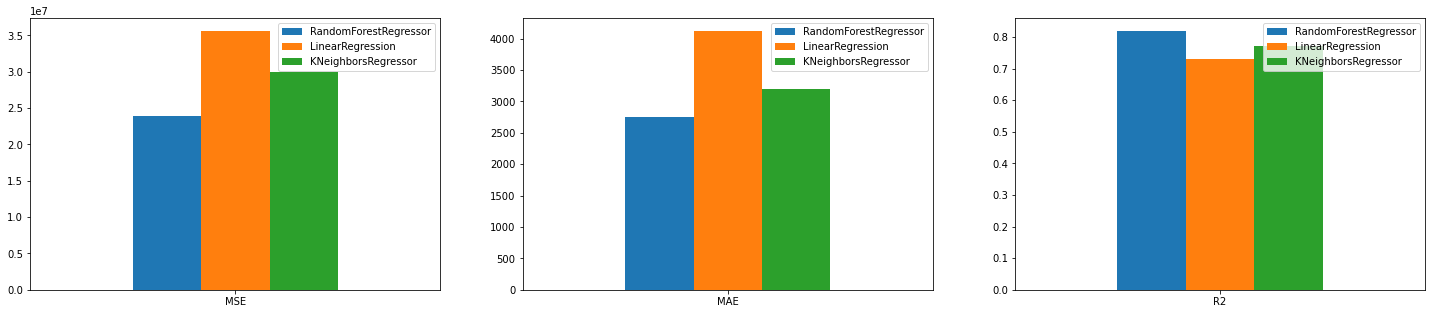

In [170]:
evaluate_models(X_test, y_test, [rfr_best, lr_best, knn_best])


#### Task 3
- ✔️ Add two dimensionality-reduction methods which are not used in CS5062 - Lab5 - Regression and Dimensionality Reduction.ipynb to the training pipelines for insurance.csv. 
- ✔️ Aim at dimensionality reduction techniques that are sufficiently different from the ones used in the example notebook. 
- ✔️ Draw conclusions from the results you observe in a markdown cell (max 250 words in a markdown cell).
  - This exercise requires us to add two dimensionality reduction methods to existing dimensionality reduction methods.
  - For that, Kernel PCA and ISOMAP are chosen as the new methods. The reason that these two methods are chosen is because the original methods[PCA, RFE(Linear SVR), RFE(LinearRegresion)] are all linear methods, and Kernel PCA & ISOMAP are non-linear methods.
  - The results of adding these two non-linear methods are however not as good. The dimensionality reduction method chosen by GridSearchCV are still the linear methods.

In [171]:
param_grid_rfr_new = [
    {
        'reduce_dim': [dim_kernel_pca],
        'reduce_dim__n_components': dim_config_n_components,
        'regression__max_depth': regressor_rf_config_depth
    },
    {
        'reduce_dim': [dim_isomap],
        'reduce_dim__n_components': dim_config_n_components,
        'regression__max_depth': regressor_rf_config_depth
    }
] + param_grid_rfr

rfr_best = train_model(param_grid_rfr_new, regressor_rf, X_train, y_train)


--------------------------------------------------------------------------------------
Best CV score(RandomForestRegressor): 0.866
Best parameters(RandomForestRegressor): {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regression__max_depth': 4}


In [172]:
param_grid_lr_new = [
    {
        'reduce_dim': [dim_kernel_pca],
        'reduce_dim__n_components': dim_config_n_components,
        'regression__normalize': regressor_lr_config_nomalize
    },
    {
        'reduce_dim': [dim_isomap],
        'reduce_dim__n_components': dim_config_n_components,
        'regression__normalize': regressor_lr_config_nomalize
    }
] + param_grid_lr

lr_best = train_model(param_grid_lr_new, regressor_lr, X_train, y_train)


--------------------------------------------------------------------------------------
Best CV score(LinearRegression): 0.751
Best parameters(LinearRegression): {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regression__normalize': False}


In [173]:
param_grid_knn_new = [
    {
        'reduce_dim': [dim_kernel_pca],
        'reduce_dim__n_components': dim_config_n_components,
        'regression__n_neighbors': regressor_knn_config_n_neighbors,
    },
    {
        'reduce_dim': [dim_isomap],
        'reduce_dim__n_components': dim_config_n_components,
        'regression__n_neighbors': regressor_knn_config_n_neighbors,
    }
] + param_grid_knn

knn_best = train_model(param_grid_knn_new, regressor_knn, X_train, y_train)


--------------------------------------------------------------------------------------
Best CV score(KNeighborsRegressor): 0.836
Best parameters(KNeighborsRegressor): {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regression__n_neighbors': 5}


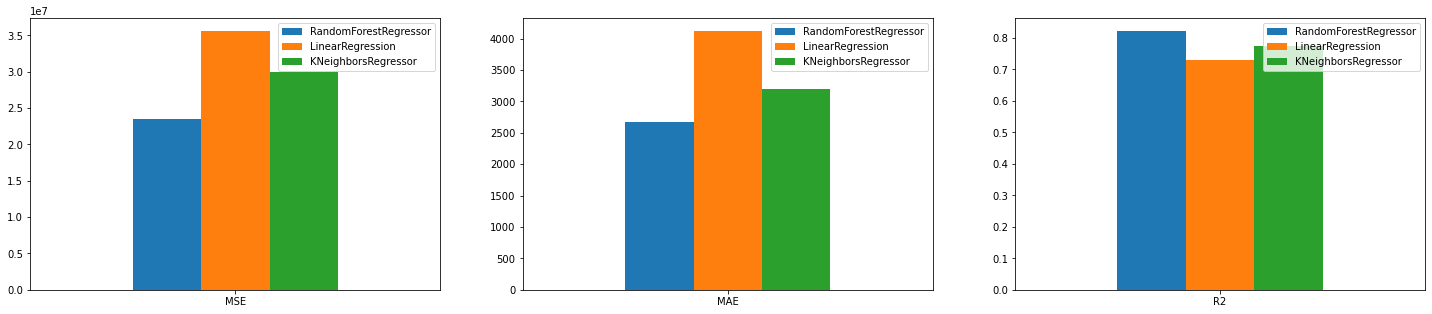

In [174]:
evaluate_models(X_test, y_test, [rfr_best, lr_best, knn_best])


#### Train Final Model

In [175]:
def transform(dict, prefix):
    dict_prefix = {key: value for key, value in dict.items() if prefix in key}
    return {key.replace(prefix, ''): value for key, value in dict_prefix.items()}


pipe = make_pipeline(preprocess_pipeline,
                     rfr_best.get('params').get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(rfr_best.get('params'), 'regression__')))

final_model = pipe.fit(X, y)


In [176]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))
